This is the code for the Bayesian regression model, which was designed to predict Vitamin C content based on only six macronutrient-level features: Water, Energy, Protein, Carbohydrates, Sodium, and Sugar. These features were standardized and modeled using a simple Bayesian linear framework.

In [10]:
# import libraries
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [11]:
x_test = pd.read_csv('features_test.csv')
y_test = pd.read_csv('y_test.csv')

x_train = pd.read_csv('features_train.csv')
y_train = pd.read_csv('y_train.csv')

In [12]:
# Remove index col
X_train = x_train[['Water', 'Energy', 'Protein', 'Carbohydrates', 'Sodium', 'Sugar']].values
y_train_vals = y_train['VitaminC'].values

X_test = x_test[['Water', 'Energy', 'Protein', 'Carbohydrates', 'Sodium', 'Sugar']].values
y_test_vals = y_test['VitaminC'].values

# Drop any rows with missing VitaminC or features 
train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

# Drop rows with NaN or infinite values
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

# Separate clean features and targets
X_train = train_data[['Water', 'Energy', 'Protein', 'Carbohydrates', 'Sodium', 'Sugar']].values
y_train_vals = train_data['VitaminC'].values

X_test = test_data[['Water', 'Energy', 'Protein', 'Carbohydrates', 'Sodium', 'Sugar']].values
y_test_vals = test_data['VitaminC'].values

print(f"Clean training samples: {len(y_train_vals)}")

Clean training samples: 4765


In [18]:
# Define Bayesian model
with pm.Model() as vitaminC_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=5, shape=X_train.shape[1])
    mu = intercept + pm.math.dot(X_train, betas)
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train_vals)

    trace = pm.sample(
    draws=2000,
    tune=1000,
    target_accept=0.9,
    random_seed=42,
    cores=1,       # only one core
    chains=4,      # 4 chains sequentially
    progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [intercept, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


In [19]:
print(az.summary(trace, var_names=["intercept", "betas", "sigma"]))

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept   9.212  3.071   3.544   15.035      0.045    0.033    4719.0   
betas[0]   -2.330  3.451  -8.637    4.425      0.048    0.035    5234.0   
betas[1]   -8.791  4.239 -16.471   -0.636      0.049    0.045    7634.0   
betas[2]   -7.015  4.292 -14.766    1.252      0.044    0.050    9434.0   
betas[3]   17.053  3.538  10.475   23.766      0.041    0.039    7487.0   
betas[4]   -0.890  4.900 -10.639    7.974      0.049    0.064   10001.0   
betas[5]    3.157  4.227  -4.772   10.924      0.041    0.049   10696.0   
sigma      66.951  0.695  65.642   68.255      0.007    0.009    9985.0   

           ess_tail  r_hat  
intercept    5449.0    1.0  
betas[0]     5896.0    1.0  
betas[1]     5827.0    1.0  
betas[2]     5488.0    1.0  
betas[3]     5730.0    1.0  
betas[4]     5471.0    1.0  
betas[5]     6179.0    1.0  
sigma        5715.0    1.0  


/var/folders/9g/wz33jks932v_m6tp7zxy4fgw0000gn/T/ipykernel_63011/1060234320.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(betas.T, hdi_prob=0.95)


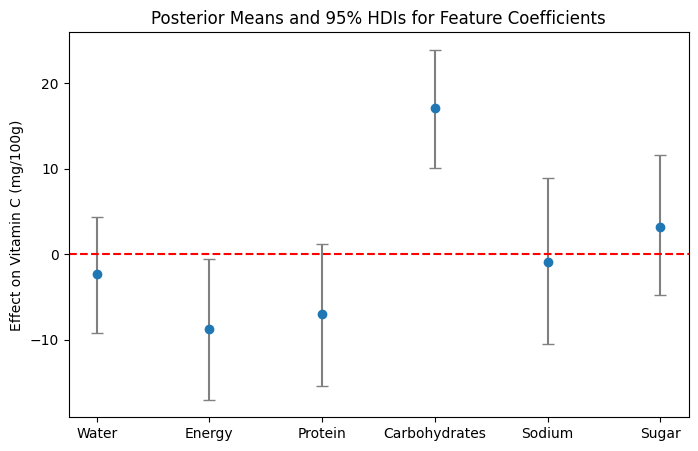

In [20]:
# Extract posterior samples
betas = trace.posterior["betas"].stack(sample=("chain", "draw")).values

feature_names = ['Water', 'Energy', 'Protein', 'Carbohydrates', 'Sodium', 'Sugar']
means = betas.mean(axis=1)
hdi = az.hdi(betas.T, hdi_prob=0.95)

plt.figure(figsize=(8,5))
plt.errorbar(feature_names, means,
             yerr=[means - hdi[:,0], hdi[:,1] - means],
             fmt='o', ecolor='gray', capsize=4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Posterior Means and 95% HDIs for Feature Coefficients")
plt.ylabel("Effect on Vitamin C (mg/100g)")
plt.show()

In [21]:
# Calculate R² and MAE for both sets 
intercept_mean = trace.posterior["intercept"].mean().item()

# Compute predictions using posterior mean parameters 
y_pred_mean_test = intercept_mean + np.dot(X_test, means)
y_pred_mean_train = intercept_mean + np.dot(X_train, means)
r2_train = r2_score(y_train_vals, y_pred_mean_train)
mae_train = mean_absolute_error(y_train_vals, y_pred_mean_train)

r2_test = r2_score(y_test_vals, y_pred_mean_test)
mae_test = mean_absolute_error(y_test_vals, y_pred_mean_test)

print("📈 Bayesian Model Performance (using posterior means):")
print(f"Training R²: {r2_train:.3f} | MAE: {mae_train:.3f} mg/100g")
print(f"Test R²:     {r2_test:.3f} | MAE: {mae_test:.3f} mg/100g")

📈 Bayesian Model Performance (using posterior means):
Training R²: 0.013 | MAE: 12.546 mg/100g
Test R²:     0.006 | MAE: 13.302 mg/100g


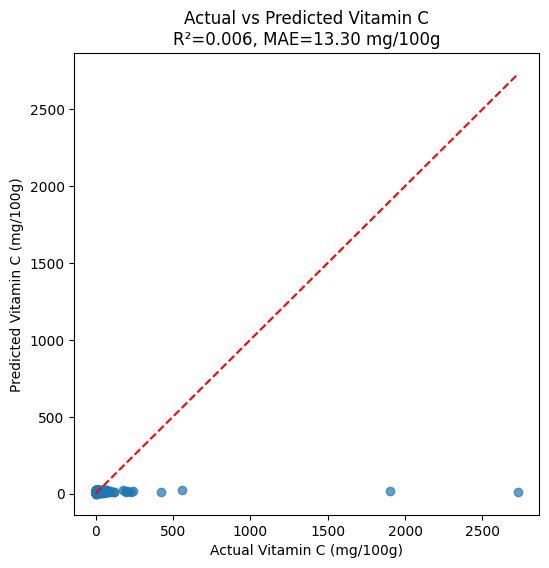

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_vals, y_pred_mean_test, alpha=0.7)
plt.plot([y_test_vals.min(), y_test_vals.max()],
         [y_test_vals.min(), y_test_vals.max()], 'r--')
plt.xlabel("Actual Vitamin C (mg/100g)")
plt.ylabel("Predicted Vitamin C (mg/100g)")
plt.title(f"Actual vs Predicted Vitamin C\nR²={r2_test:.3f}, MAE={mae_test:.2f} mg/100g")
plt.show()

This model achieved an extremely low coefficient of determination (R² ≈ 0.006 on the test set and ≈ 0.013 on the training set) with a mean absolute error (MAE) of roughly 13 mg of Vitamin C per 100 g. In practical terms, this indicates that the relationship between basic nutrient composition and Vitamin C content is extremely weak. Posterior analysis revealed that carbohydrates had a slightly positive association with Vitamin C, while nutrients such as Energy and Protein showed weak negative trends (which makes sense since Vitamin C is typically found in fruits/vegetables). However, the credible intervals for nearly all coefficients overlapped zero, implying substantial uncertainty. The model concluded that macronutrients alone are not reliable predictors of Vitamin C, and that most of the observed variation in Vitamin C likely arises from unobserved categorical factors (for example, whether a food is plant- or animal-based) rather than continuous nutrient values. In short, the basic model was statistically sound but biologically under-informed, providing more evidence about what doesn’t predict Vitamin C than what does. 